In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}") 

device : cuda


Parameters to be used for data prep

In [22]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

## Data Prep

Create normal train data

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize image to [-1, 1]

normal_train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(normal_train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

Files already downloaded and verified


Create Augmented train data 

In [24]:
# Define data transformations with augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate image at an arbitrary angle (-10 to +10 degrees)
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Crop and resize from the center
    transforms.RandomHorizontalFlip(),  # Flip image horizontally (mirror image)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Create augmented training dataset
augmented_train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=augmentation_transform)

augmented_train_loader = torch.utils.data.DataLoader(augmented_train_data, batch_size=batch_size,
                                           num_workers=num_workers)

# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [25]:
# load test data (note that the data has been transformed already)
test_images = torch.load('../input/testset/test_image.pt')

## Take a look at your image data

torch.Size([20, 3, 32, 32]) tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6])


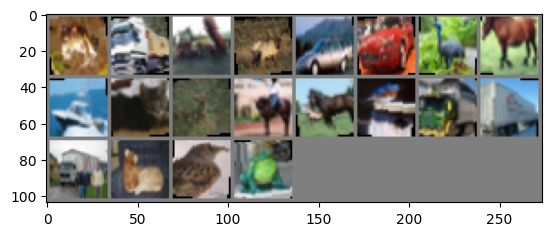

frog  truck truck deer  car   car   bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog 


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random batch of training images
dataiter = iter(augmented_train_loader)
images, labels = next(dataiter)

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN - ResNet18

In [28]:
from torchvision.models import resnet18
model = resnet18(pretrained=False,num_classes=10)

## Optimizers and Loss Function

In [29]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Train CNN on training data 

In [30]:
train_losses = []  # Store training losses
model.to(device)
total_epoch = 50
for epoch in range(total_epoch): 
    train_loss = 0.0
    for data, target in augmented_train_loader: 
        # move data and target to the same device as the model
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data) # forward pass
        loss = criterion(outputs, target) # calc loss
        loss.backward() # back propagation
        optimizer.step() # one step gradient descent
        # update training loss
        train_loss += loss.item() * data.size(0)
    
    # Print the average loss for the epoch
    average_loss = train_loss / len(augmented_train_loader)
    train_losses.append(average_loss)
    print(f'Epoch {epoch + 1} / {total_epoch}, Average Loss: {average_loss:.3f}')
    
print('Finished Training')

Epoch 1 / 50, Average Loss: 36.747
Epoch 2 / 50, Average Loss: 31.494
Epoch 3 / 50, Average Loss: 29.379
Epoch 4 / 50, Average Loss: 27.909
Epoch 5 / 50, Average Loss: 26.639
Epoch 6 / 50, Average Loss: 25.576
Epoch 7 / 50, Average Loss: 24.582
Epoch 8 / 50, Average Loss: 23.766
Epoch 9 / 50, Average Loss: 22.920
Epoch 10 / 50, Average Loss: 22.177
Epoch 11 / 50, Average Loss: 21.618
Epoch 12 / 50, Average Loss: 20.958
Epoch 13 / 50, Average Loss: 20.407
Epoch 14 / 50, Average Loss: 19.859
Epoch 15 / 50, Average Loss: 19.250
Epoch 16 / 50, Average Loss: 18.835
Epoch 17 / 50, Average Loss: 18.447
Epoch 18 / 50, Average Loss: 17.933
Epoch 19 / 50, Average Loss: 17.517
Epoch 20 / 50, Average Loss: 17.077
Epoch 21 / 50, Average Loss: 16.587
Epoch 22 / 50, Average Loss: 16.267
Epoch 23 / 50, Average Loss: 15.929
Epoch 24 / 50, Average Loss: 15.585
Epoch 25 / 50, Average Loss: 15.078
Epoch 26 / 50, Average Loss: 14.821
Epoch 27 / 50, Average Loss: 14.380
Epoch 28 / 50, Average Loss: 14.013
E

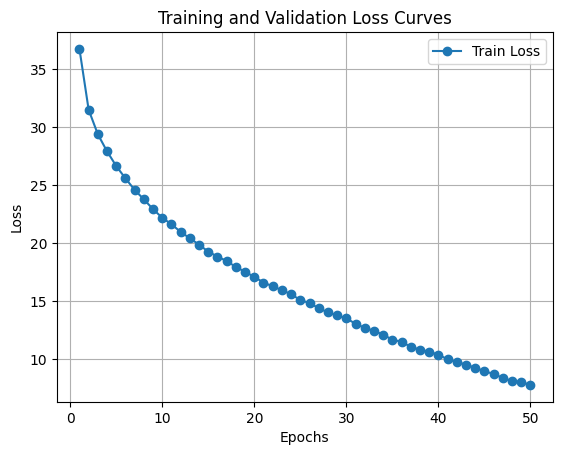

In [31]:
import matplotlib.pyplot as plt
# Plot the training and validation loss curve
plt.plot(range(1, total_epoch + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## Make prediction on test images

['cat' 'dog' 'frog' ... 'plane' 'cat' 'bird']


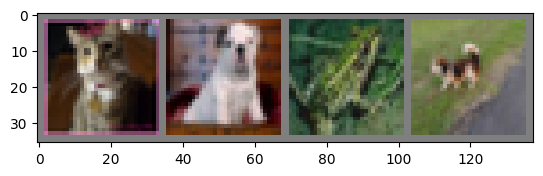

,label
0,cat
1,dog
2,frog
3,dog
4,truck
...,...
4995,deer
4996,ship
4997,plane
4998,cat


In [32]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])

print(predicted)
# show images
imshow(torchvision.utils.make_grid(test_images[:4]))

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("ResNet18_50_SGD.csv", index=True, index_label='id')
submission